<a href="https://colab.research.google.com/github/JSKimGitHub/real_time_driving_predictor/blob/main/do_ewc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 초기화

In [ ]:
!pip install opencv-python numpy matplotlib ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# CSV 파일 경로 지정 (구글 드라이브 마운트 경로 포함)
file_path = '/content/drive/MyDrive/towtruck_8_results.csv'
file_path2 = '/content/drive/MyDrive/Uturn_7_dlabeled.csv'
file_path3 = '/content/drive/MyDrive/driving_11_dlabeled.csv'
file_path4 = '/content/drive/MyDrive/driving_12_dlabeled.csv' # 예시: 파일명이 '파일명.csv'인 경우

# CSV 파일을 DataFrame으로 읽어오기
driving11 = pd.read_csv(file_path3)
truck8 = pd.read_csv(file_path)
uturn7 = pd.read_csv(file_path2)
driving12 = pd.read_csv(file_path4)

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import os

# YOLOv8 모델 로드
model = YOLO("yolov8n.pt")  # 가장 가벼운 모델

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import torch
import torch.nn as nn

class FM_FTRL_Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim=8, k=4):
        super().__init__()
        self.linear = nn.Linear(input_dim, embedding_dim)
        self.V = nn.Parameter(torch.randn(input_dim, k) * 0.01)
        self.embedding_dim = embedding_dim

    def forward(self, x):
        linear_part = self.linear(x)
        fm_interactions = 0.5 * torch.sum(
            (x @ self.V) ** 2 - (x ** 2) @ (self.V ** 2),
            dim=1, keepdim=True
        )
        fm_interactions_expanded = fm_interactions.reshape(-1, 1).expand(-1, self.embedding_dim)
        return linear_part + fm_interactions_expanded

class FM_FTRL_WithClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim=8, k=4):
        super().__init__()
        self.encoder = FM_FTRL_Encoder(input_dim, embedding_dim, k)
        self.classifier = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        embedding = self.encoder(x)
        logits = self.classifier(embedding)
        return torch.sigmoid(logits).squeeze(1), embedding

class EWCWrapper:
    def __init__(self, model, lambda_ewc=1000.0):
        self.model = model
        self.lambda_ewc = lambda_ewc
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._fisher = {}

    def consolidate(self, dataloader, device):
        self._means = {n: p.clone().detach() for n, p in self.params.items()}
        fisher = {n: torch.zeros_like(p) for n, p in self.params.items()}

        self.model.eval()
        for x in dataloader:
            x = x.to(device)
            self.model.zero_grad()
            out, _ = self.model(x)
            loss = out.mean()
            loss.backward()

            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher[n] += p.grad.data.clone().pow(2)

        for n in fisher:
            fisher[n] = fisher[n] / len(dataloader)
        self._fisher = fisher

    def penalty(self):
        loss = 0
        for n, p in self.model.named_parameters():
            if n in self._fisher:
                loss += (self._fisher[n] * (p - self._means[n]) ** 2).sum()
        return self.lambda_ewc * loss

In [ ]:
import torch.optim as optim

In [ ]:
# ===== 데이터 전처리 함수 =====
def preprocess_input(cls_id, conf, dist, area, cx, cy, num_classes=10):
    x = np.zeros(num_classes + 5)
    if 0 <= cls_id < num_classes:
        x[cls_id] = 1.0
    x[num_classes:] = [conf, dist / 100, area / 10000, cx / 1920, cy / 1080]
    return torch.tensor(x, dtype=torch.float32).unsqueeze(0)

def add_noise(x, level=0.1):
    return x + level * torch.randn_like(x)

In [ ]:
# ===== 환경 설정 =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("yolov8n.pt")  # YOLOv8
input_dim = 10 + 5
fm_model = FM_FTRL_WithClassifier(input_dim)
optimizer = optim.Adam(fm_model.parameters(), lr=1e-3)
ewc = EWCWrapper(fm_model)

fm_model.to(device)
fm_model.train()
loss_fn = nn.MSELoss()

loss_buffer = []
action_buffer = []
measuring_loss = False
video_file_count = 0

# driving 11은 학습시킨 라벨로 돌림.

In [ ]:
driving11=driving11['go_stop_decision']

In [ ]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
video_path = next(iter(uploaded))

In [ ]:
# ===== 테스트용 비디오 불러오기 =====
#video_path = "/content/test_video.mp4"  # Colab에 업로드 후 경로 수정
cap = cv2.VideoCapture(video_path)

frame_idx = 0
step=0;
measuring_loss = True
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []


    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        area = (x2 - x1) * (y2 - y1)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

        x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
        x_noisy = add_noise(x)

        y_pred, emb_orig = fm_model(x)
        _, emb_noisy = fm_model(x_noisy)

        ewc_loss = ewc.penalty()

        label = torch.tensor([driving[frame_idx-1]], dtype=torch.float32).to(device)
        supervised_loss = loss_fn(y_pred, label)
        loss = supervised_loss + 0.1 * ewc_loss

        if measuring_loss:
          loss_buffer.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        act = int(y_pred.item() >= 0.5)
        frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        action_buffer.append(final_act)


cap.release()

print("EWC Action Buffer:", action_buffer)
print("Loss Buffer:", loss_buffer)
print(frame_idx)

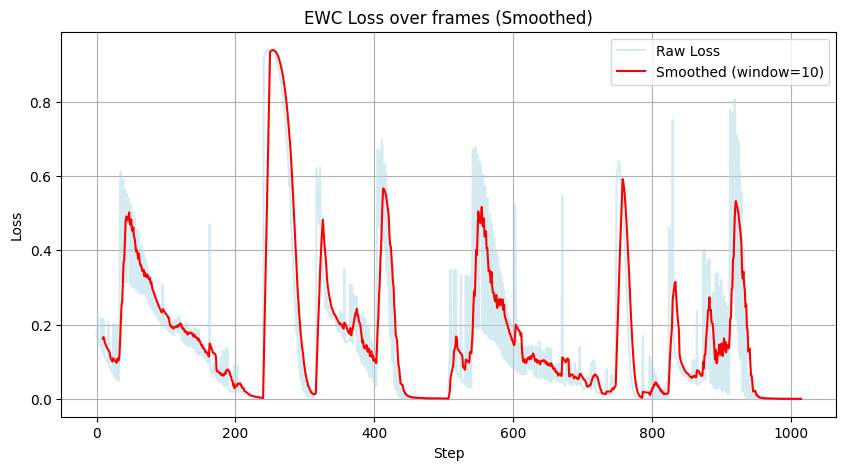

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 이동평균 함수
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 원본 데이터
plt.figure(figsize=(10, 5))
plt.plot(loss_buffer, color='lightblue', alpha=0.5, label='Raw Loss')

# 이동평균 데이터
smoothed_loss = moving_average(loss_buffer, 10)
plt.plot(range(10-1, len(loss_buffer)), smoothed_loss, color='red', label='Smoothed (window=10)')

plt.title("EWC Loss over frames (Smoothed)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

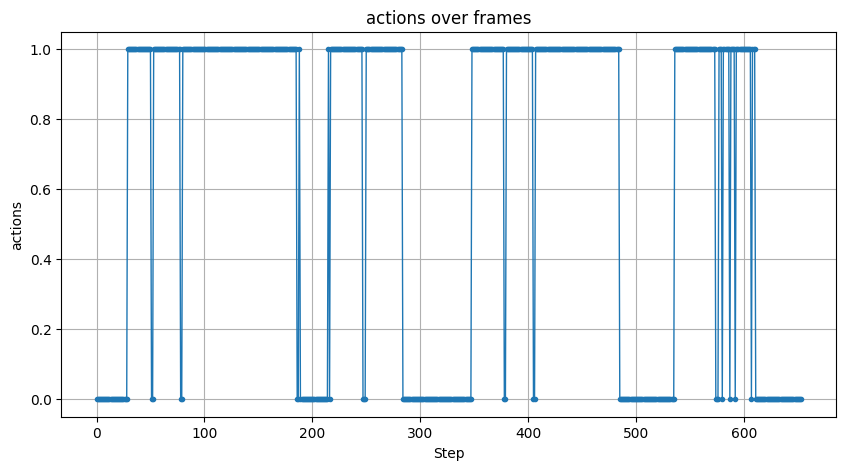

In [ ]:
import matplotlib.pyplot as plt

# Loss 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(action_buffer, marker='o', markersize=3, linewidth=1)
plt.title("actions over frames")
plt.xlabel("Step")
plt.ylabel("actions")
plt.grid(True)
plt.show()

# 이후는 라벨 없이 돌림.

In [ ]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
video_path = next(iter(uploaded))

In [ ]:
# ===== 테스트용 비디오 불러오기 =====
#video_path = "/content/test_video.mp4"  # Colab에 업로드 후 경로 수정
cap = cv2.VideoCapture(video_path)

frame_idx = 0
step=0;
measuring_loss = True
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    step += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []


    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if conf <= 0.6:
              continue
        else:
          x1, y1, x2, y2 = map(int, box.xyxy[0])
          area = (x2 - x1) * (y2 - y1)
          cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
          est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

          x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
          x_noisy = add_noise(x)

          y_pred, emb_orig = fm_model(x)
          _, emb_noisy = fm_model(x_noisy)

          ewc_loss = ewc.penalty()

          loss = loss_fn(emb_noisy, emb_orig.detach())
          loss = loss + 0.1 * ewc_loss
          if measuring_loss:
              loss_buffer.append(loss.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          act = int(y_pred.item() >= 0.5)
          frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        action_buffer.append(final_act)

cap.release()

print("EWC Action Buffer:", action_buffer)
print("Loss Buffer:", loss_buffer)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 이동평균 함수
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 원본 데이터
plt.figure(figsize=(10, 5))
plt.plot(loss_buffer, color='lightblue', alpha=0.5, label='Raw Loss')

# 이동평균 데이터
smoothed_loss = moving_average(loss_buffer, 10)
plt.plot(range(10-1, len(loss_buffer)), smoothed_loss, color='red', label='Smoothed (window=10)')

plt.title("EWC Loss over frames (Smoothed)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Loss 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(action_buffer, marker='o', markersize=3, linewidth=1)
plt.title("actions over frames")
plt.xlabel("Step")
plt.ylabel("actions")
plt.grid(True)
plt.show()

# 모델 평가하기

In [ ]:
final_tasks=[]

In [ ]:
final_labels=[]

In [ ]:
import numpy as np

def compute_cl_metrics(final_tasks, final_labels, baseline_acc=0.5):
    """
    Continual Learning metrics: IM, FWT, BWT 계산
    - IM (Initial Accuracy): 각 태스크 처음 배운 직후의 평균 정확도
    - FWT (Forward Transfer): baseline 대비 이후 태스크 성능 향상
    - BWT (Backward Transfer): 마지막 학습 후 이전 태스크 성능 변화
    """

    num_tasks = len(final_tasks)
    task_accuracies = []

    # 태스크별 정확도 계산
    for idx in range(num_tasks):
        preds = np.array(final_tasks[idx]).flatten()
        labels = np.array(final_labels[idx]).flatten()

        if preds.size == 0 or labels.size == 0:
            acc = 0.0
        else:
            acc = np.mean(preds == labels)

        task_accuracies.append(acc)

    task_accuracies = np.array(task_accuracies)
    print("Task accuracies:", task_accuracies)

    # IM
    IM = np.mean(task_accuracies) if num_tasks > 0 else 0.0

    # FWT
    if num_tasks > 1:
        FWT = np.mean(task_accuracies[1:] - baseline_acc)
    else:
        FWT = 0.0

    # BWT
    if num_tasks > 1:
        BWT = np.mean(task_accuracies[-1] - task_accuracies[:-1])
    else:
        BWT = 0.0

    return IM, FWT, BWT


## !! 여기서부터 다시 돌리기 !!

In [ ]:
fm_model.eval()
loss_fn = nn.MSELoss()

test_loss_buffer = []
test_action_buffer = []
measuring_loss = False
test_video_file_count = 0

In [ ]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
test_video_path = next(iter(uploaded))

Saving Uturn_7.mov to Uturn_7 (2).mov


In [ ]:
# ===== 테스트용 비디오 불러오기 =====
#video_path = "/content/test_video.mp4"  # Colab에 업로드 후 경로 수정
cap = cv2.VideoCapture(test_video_path)

frame_idx = 0
step=0;
measuring_loss = True
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    step += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []


    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        area = (x2 - x1) * (y2 - y1)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

        x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
        x_noisy = add_noise(x)

        y_pred, emb_orig = fm_model(x)
        _, emb_noisy = fm_model(x_noisy)

        ewc_loss = ewc.penalty()

        loss = loss_fn(emb_noisy, emb_orig.detach())
        loss = loss + 0.1 * ewc_loss
        if measuring_loss:
            test_loss_buffer.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        act = int(y_pred.item() >= 0.5)
        frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        test_action_buffer.append(final_act)

cap.release()


print("EWC Action Buffer:", test_action_buffer)
print("Loss Buffer:", test_loss_buffer)


In [ ]:
test_frame_labels=uturn7['go_stop_decision'] # 여기에 driving12, truck8, uturn7을 값을 바꿔가며 넣기

In [ ]:
print(type(test_action_buffer))
print(type(test_frame_labels))
print(len(test_action_buffer))
print(len(test_frame_labels))


In [ ]:
final_tasks.append(test_action_buffer)
final_labels.append(test_frame_labels)

In [ ]:
IM, FWT, BWT = compute_cl_metrics(final_tasks, final_labels)

print(f"IM (Initial Accuracy): {IM:.3f}")
print(f"FWT (Forward Transfer): {FWT:.3f}")
print(f"BWT (Backward Transfer): {BWT:.3f}")
